# Import

In [1]:
import numpy as np
import pandas as pd
from lib.utils import read_pickle
from lib.visualization import set_arena
from os.path import join
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# In order to use Webots API, Replace the path to your webots library
# You could also set it in your OS system.
# If the path is not added, you would encounter  "ModuleNotFoundError: No module named 'controller'"
import sys
sys.path.insert(0, r'C:\Program Files\Webots\lib\controller\python')
    

# Reinforcement learning performance

In [2]:
from scipy.ndimage import gaussian_filter1d

def load_moniter(project_dir, chpt_name, max_chpt_num):

    # Append traj data and fsigma
    allmonitorlist = []
    for i in range(1, max_chpt_num+1):
        monitor_pth = join(project_dir, chpt_name.replace('$', '%d'%i) + '.monitor.csv')
        monitor_df_each = pd.read_csv(monitor_pth, skiprows=[0])  # a list of dictionaries, each for one episode
        allmonitorlist.append(monitor_df_each)
    monitor_df = pd.concat(allmonitorlist, ignore_index=True)
    monitor_df['cuml'] = monitor_df['l'].cumsum()
    monitor_df

    return monitor_df

def get_stats(monitor_df):
    cuml = monitor_df['cuml']
    r = monitor_df['r']
    r_gau = gaussian_filter1d(r, sigma=20)

    done = monitor_df['terminated']*1.0
    # done = (monitor_df['r'] > 0.99) * 1.0
    done_gau = gaussian_filter1d(done, sigma=20)

    winmask = monitor_df['terminated'] == 1
    # winmask = monitor_df['r'] > 2
    windf = monitor_df[winmask]
    wincuml = windf['cuml']
    winl = windf['l']
    winl_gau = gaussian_filter1d(winl, sigma=5)

    return (cuml, r_gau, done_gau), (wincuml, winl, winl_gau)


def plot_winstats(ax, cuml, r_gau, done_gau, wincuml, winl, winl_gau, label):
    ax[0].plot(cuml, r_gau/2.5, label=label)
    ax[0].set_ylim(0, 1)
    ax[0].set_ylabel('Total R')
    ax[1].plot(cuml, done_gau, label=label)
    ax[1].set_ylim(-0.2, 1.0)
    ax[1].set_ylabel('Win rate')
    ax[2].scatter(wincuml, winl, marker='.', label=label, alpha=0.2)
    ax[2].plot(wincuml, winl_gau)
    ax[2].set_ylim(0, 360)
    ax[2].set_ylabel('Time steps to win')
    ax[2].set_xlabel('Cumulative time step of all episodes')
    ax[0].legend()


In [3]:
project_name1 = 'RegressedToTrueState'
project_name2 = 'UmapDirect'
project_name3 = 'RegressedToUmapState'
load_dir = join('data', 'OnlineAnalysis')
chpt_name = 'PPO$'
monitor_df1 = load_moniter(join(load_dir, project_name1), 'PPO$', 5)
monitor_df2 = load_moniter(join(load_dir, project_name2), 'PPO$', 11)
monitor_df3 = load_moniter(join(load_dir, project_name3), 'PPO$', 5)

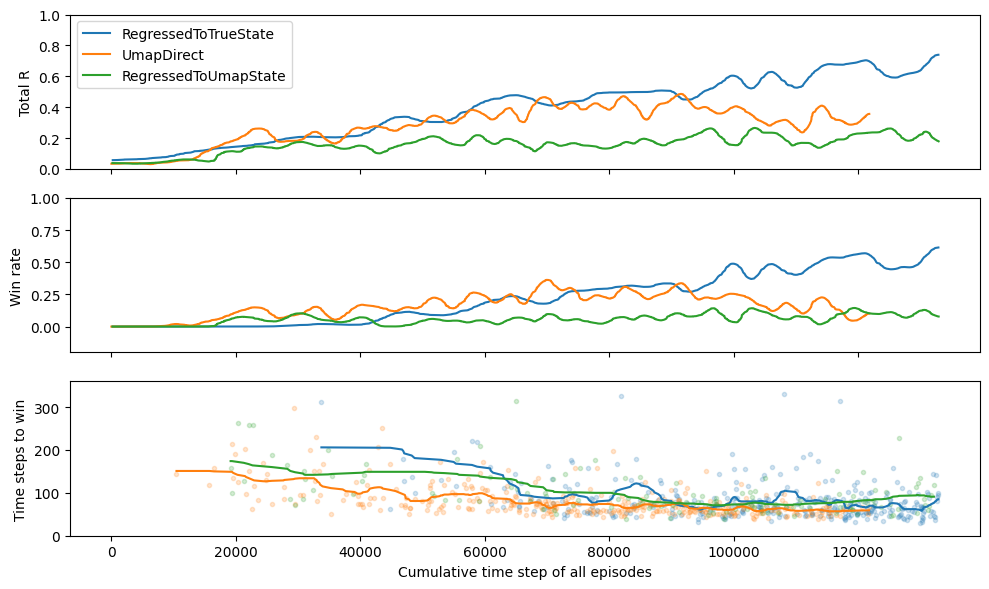

In [4]:
(cuml1, r_gau1, done_gau1), (wincuml1, winl1, winl_gau1) = get_stats(monitor_df1)
(cuml2, r_gau2, done_gau2), (wincuml2, winl2, winl_gau2) = get_stats(monitor_df2)
(cuml3, r_gau3, done_gau3), (wincuml3, winl3, winl_gau3) = get_stats(monitor_df3)

fig, ax = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
plot_winstats(ax, cuml1, r_gau1, done_gau1, wincuml1, winl1, winl_gau1, label=project_name1)
plot_winstats(ax, cuml2, r_gau2, done_gau2, wincuml2, winl2, winl_gau2, label=project_name2)
plot_winstats(ax, cuml3, r_gau3, done_gau3, wincuml3, winl3, winl_gau3, label=project_name3)
fig.tight_layout()
fig.savefig(join('data', 'WinStatistics_3.png'), dpi=300)

# Robot's behavior analysis

## Organize dataframes by concatenating episodes

In [5]:
# Concatenate Trajectories
project_name = 'RegressedToUmapState'
max_ckpts = 5
project_dir = join(load_dir, project_name)
save_dir = join(project_dir, 'win_trajs')
os.makedirs(save_dir, exist_ok=True)
keys = ['x', 'y', 'a', 't', 'sid', 'truncated', 'terminated', 'embedid', 'r']
data_dict = {key: [] for key in keys}
data_dict['epi'] = []
epi = 0
for i in range(1, max_ckpts+1):
    load_trajdata_pth = join(project_dir, 'PPO%d_trajdata.pickle'%i)
    trajdata = read_pickle(load_trajdata_pth)
    for j in range(len(trajdata)):
        episode = trajdata[j]
        
        for key in keys:
            data_dict[key].extend(episode[key])
        data_dict['epi'].extend([epi]*len(episode['t']))
        epi +=1
trajdf = pd.DataFrame(data_dict)

## Final poses and states when the robot fails

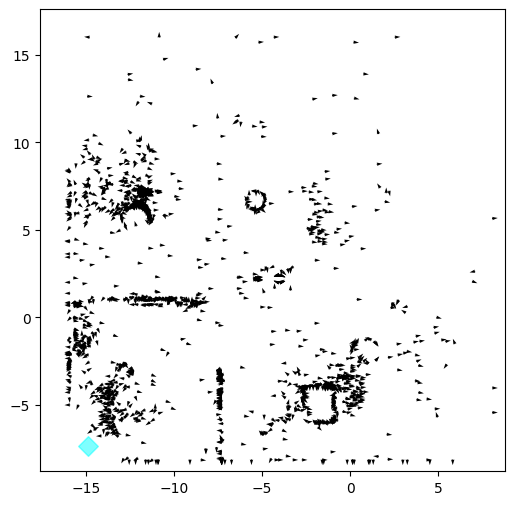

In [6]:

fail_epis = trajdf.loc[trajdf['r']== -0.01, 'epi']

N = len(fail_epis)
allx, ally, alla = np.zeros(N), np.zeros(N), np.zeros(N)
sid, embedid = np.zeros(N), np.zeros(N)
for i, epi in enumerate(fail_epis):
    episodedf = trajdf[trajdf['epi'] == epi]
    xyas = episodedf[list('xya')+['sid', 'embedid']].to_numpy()
    allx[i], ally[i], alla[i], sid[i], embedid[i] = xyas[-1, :]
    
fig, ax = plt.subplots(figsize=(6, 6))
set_arena(ax)
ax.quiver(allx, ally, np.cos(alla), np.sin(alla))

## Accuracy of hipposlam in failing and winning episodes

In [7]:
# Accuracy of hipposlam state decoder (J, predicted_state = sid) predicting the UMAP embedding (embedid)
# The failing episode has even a higher accuracy than winning episode, indicating the hipposlam state decoding is not the cause of the low performance.
def state_acc(trajdf, epis):
    all_matchmask = []
    for i, epi in enumerate(epis):
        episodedf = trajdf[trajdf['epi'] == epi]
        matchmask = episodedf['sid'] == episodedf['embedid']
        all_matchmask.extend(matchmask)
    return np.mean(all_matchmask)
fail_epis = trajdf.loc[trajdf['r']== -0.01, 'epi']
win_epis = trajdf.loc[trajdf['r'] > 0, 'epi']
winacc = state_acc(trajdf, np.unique(win_epis))
failacc = state_acc(trajdf, np.unique(fail_epis))
print(winacc, failacc)

    
    

0.22724358025787486 0.24152496298836537


## Plot winning trajectroies for visualization

  0%|          | 0/134 [00:00<?, ?it/s]


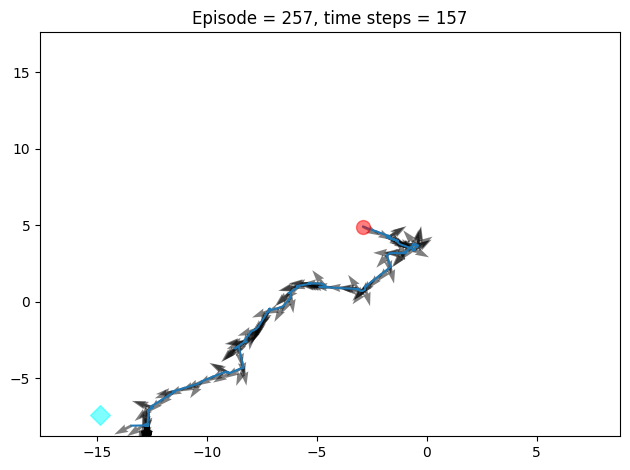

In [8]:
win_epis = np.unique(trajdf[trajdf['r'] == 1]['epi'])
for win_epi in tqdm(win_epis):
    
    mask = trajdf['epi'] == win_epi
    
    xya = trajdf[mask][list('xya')].to_numpy()
    
    fig, ax = plt.subplots()
    
    ax.scatter(xya[0, 0], xya[0, 1], c='r', marker='o', zorder=3.1, s=100, alpha=0.5)
    ax.quiver(xya[:, 0], xya[:, 1], np.cos(xya[:, 2]), np.sin(xya[:, 2]), scale=30, alpha=0.5)
    ax.plot(xya[:, 0], xya[:, 1])
    set_arena(ax)
    ax.set_title('Episode = %d, time steps = %d'%(win_epi, xya.shape[0]))
    fig.tight_layout()
    fig.savefig(join(save_dir, '%d.png'%(win_epi)), dpi=200)
    plt.close(fig)
    # break

## State comparisons

Comparing the poses of the robot at the predicted states (sid, by hipposlam) and umap states, to see if hipposlam can correctly decode the umap states

  0%|          | 0/624 [00:00<?, ?it/s]


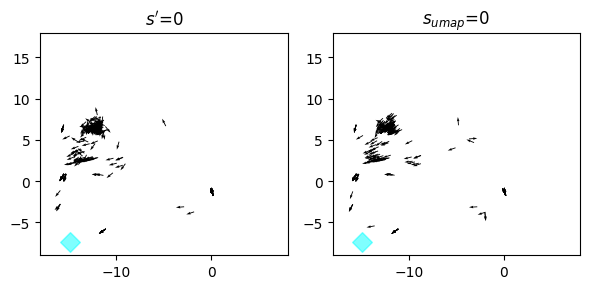

In [10]:

unique_sids = np.unique(trajdf['embedid'])
xbound = (-18, 8)
ybound = (-9, 18)
i = 0
save_dir = join(project_dir, 'state_compares')
os.makedirs(save_dir, exist_ok=True)
for unique_sid in tqdm(unique_sids):
    
    mask_sid = trajdf['sid'] == unique_sid
    mask_eid = trajdf['embedid'] == unique_sid
    
    xyas = trajdf[mask_sid][list('xya')].to_numpy()
    xyae = trajdf[mask_eid][list('xya')].to_numpy()
    
    fig, ax = plt.subplots(1, 2, figsize=(6,3))
    ax[0].quiver(xyas[:, 0], xyas[:, 1], np.cos(xyas[:, 2]), np.sin(xyas[:, 2]), scale=30)
    ax[1].quiver(xyae[:, 0], xyae[:, 1], np.cos(xyae[:, 2]), np.sin(xyae[:, 2]), scale=30)
    
    for axe in ax:
        set_arena(axe)
        axe.set_xlim(*xbound)
        axe.set_ylim(*ybound)
        
    ax[0].set_title(r'$s^\prime$=%d'%unique_sid)
    ax[1].set_title(r'$s_{umap}$=%d'%unique_sid)
    fig.tight_layout()
    fig.savefig(join(save_dir, '%d.png'%(unique_sid)), dpi=200)
    plt.close(fig)
    # break

# Plot Spatial Specificity for unique UMAP state

In [13]:
project_name = 'RegressedToUmapState'
project_dir = join(load_dir, project_name)
max_chpt_num = 5
keys = ['x', 'y', 'a', 't', 'sid', 'embedid']
data_dict = {key: [] for key in keys}

for i in range(1, max_chpt_num + 1):
    load_trajdata_pth = join(project_dir, 'PPO%d_trajdata.pickle'%i)
    trajdata = read_pickle(load_trajdata_pth)
    for j in range(len(trajdata)):
        episode = trajdata[j]
        for key in keys:
            data_dict[key].extend(episode[key])
trajdf = pd.DataFrame(data_dict)

  0%|          | 0/629 [00:01<?, ?it/s]


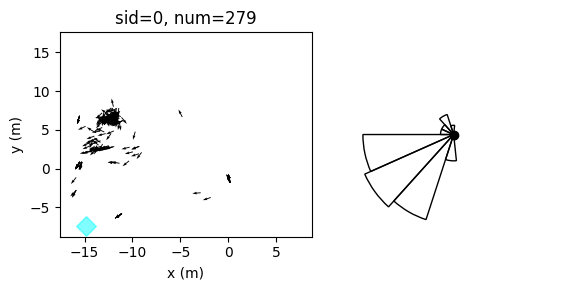

In [14]:
from lib.visualization import plot_spatial_specificity
unique_sids = np.unique(trajdf['sid'])
aedges = np.linspace(-np.pi, np.pi, 16)

save_imgs_dir = join(project_dir, 'umap_state_specificity')
os.makedirs(save_imgs_dir, exist_ok=True)
for unique_sid in tqdm(unique_sids):
    subdf = trajdf[trajdf['sid'] == unique_sid]
    xya = subdf[list('xya')].to_numpy()
    title = f'sid={unique_sid}, num={xya.shape[0]}'
    fig, (ax0, ax1) = plot_spatial_specificity(xya, aedges, xbound, ybound, title=title, figsize=(6,3))
    ax0.set_xlabel('x (m)')
    ax0.set_ylabel('y (m)')
    fig.tight_layout()
    fig.savefig(join(save_imgs_dir, '%d.png'%unique_sid), dpi=200)
    plt.close(fig)
    # break